# CS 598 DLH Final Project
## Conditional Graph Information Bottleneck for Molecular Relational Learning
github repo: [https://github.com/mollytyy/CS598DLH_Final_Project](https://github.com/mollytyy/CS598DLH_Final_Project)

## I. Introduction
With its extensive and complex datasets, the expanding field of molecular biology presents significant challenges for traditional computational analysis methods. Deep learning (DL) provides robust frameworks for managing these complexities, aiding progress in understanding molecular structures and their interactions. A notable contribution in this area is the "Conditional Graph Information Bottleneck for Molecular Relational Learning," which utilizes the principles of information bottleneck theory within graph neural networks (GNNs) for molecular data analysis [8, 9]. This method is a considerable advancement in computational biology, offering a sophisticated approach to extracting relevant information from molecular structures and their relational data.  

Molecular relational learning is a key challenge in computational biology, addressing the complex network of relationships and properties found in molecular data[12]. The authors of the study introduce a new architecture that effectively extracts and processes this molecular information, providing insights into molecular properties and interactions. Their work, based on deep learning and graph neural networks, not only shows how deep learning can improve our understanding of molecular systems but also sets a new benchmark for future studies in this area.

This project is motivated by the essential need to assess and understand the methodologies introduced in the paper[1]. By replicating the original study's experiments and examining additional applications of the proposed architecture, this project target to confirm the original findings and explore the model's applicability to various molecular datasets. The objective is to deepen our knowledge of how Deep Learning can be applied to understand molecular structures and their properties, thereby making a valuable contribution to the fields of computational biology and molecular research.  

The Conditional Graph Information Bottleneck (CGIB) approach introduces a new method for analyzing molecular data, balancing detailed analysis with the practical limits of computational resources[1]. This project builds upon this foundation, testing the CGIB model's robustness with different molecular datasets and applying it to new challenges within molecular biology. By thoroughly replicating and evaluating the original work, this project allows us gain a deep understanding of ongoing research on deep learning's potential to address the complexities of molecular science. 

## II. Scope of Reproducibility

In this section, we will validate the claims made by the CGIB paper through a series of experiments designed to test the framework's applicability and effectiveness across different molecular relational learning tasks. Specifically, we focus on the following experiments as outlined in the original work:
1. DrugDrugInteraction: This experiment investigates the potential of CGIB in predicting interactions between drug pairs, a crucial task in drug discovery and safety assessment.
2. MolecularInteraction: Here, the focus is on understanding the interactions between molecules, which is vital for applications in material science and chemical engineering.
3. SimilarityLearning: This task explores the framework's ability to learn and quantify the similarity between molecular structures, an essential aspect of computational chemistry for clustering, searching, and predicting molecular properties.


For each of these experiments, we will test the following hypotheses derived from the paper:
Hypothesis 1: CGIB can identify core subgraphs within molecular pairs that are crucial for predicting their interaction behavior, outperforming baseline methods that do not condition on the interaction partner.
Hypothesis 2: The performance improvements offered by CGIB are consistent across different molecular relational learning tasks, including but not limited to solubility prediction, reaction outcome prediction, and drug-drug interaction prediction.


To test these hypotheses, we will replicate the experiments conducted in the original paper, focusing on the following aspects:
1. Data: Utilize the same or a subset of the datasets used in the paper to ensure comparability.
2. Model Implementation: Reconstruct the CGIB model based on the descriptions and code provided in the paper.
3. Training: Follow the training procedures outlined in the paper, including computational requirements.
4. Evaluation: Apply the same metrics used in the paper to assess model performance.

Through this reproducibility study, we aim to assess the robustness and generalizability of the CGIB method, contributing to a deeper understanding of its strengths and limitations.

## III. Methodology
#### Environment

* python: 3.7.10
* torch: 1.8.1+cu111
* torch-geometric: 1.7.0
* torch-scatter: 2.0.8
* torch-sparse: 0.6.12

(see requirements.txt for a complete list)

In [2]:
!pip install -r requirements.txt
!pip install torch==1.8.1+cu111 torchvision==0.9.1+cu111 torchaudio==0.8.1 -f https://download.pytorch.org/whl/torch_stable.html    

Looking in links: https://download.pytorch.org/whl/torch_stable.html


In [1]:
import pandas as pd
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from DrugDrugInteraction.data import build_dataset
from DrugDrugInteraction.utils import get_stats, write_summary, write_summary_total
from torch import optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch_geometric.nn import Set2Set
from DrugDrugInteraction.embedder import embedder
from DrugDrugInteraction.layers import GINE
from DrugDrugInteraction.utils import create_batch_mask
from torch_scatter import scatter_mean, scatter_add, scatter_std


#### Data

Drug Drug Interaction uses dataset from [MIRACLE](https://github.com/isjakewong/MIRACLE/tree/main/MIRACLE/datachem) Multi-view Graph Contrastive Representation Learning for Drug-drug Interaction Prediction. ZhangDDI is the smallest out of three datasets evaluated in the paper - ZhangDDI, ChCh-Miner, and DeepDDI. This dataset contains 548 drugs and 48,548 pairwise DDI and multiple types of similarity information about these drug pairs. An example of the dataset is shown below

| drugbank_id_1	| drugbank_id_2 | smiles_2 | smiles_1 | cid_1 | cid_2 | label |
| --- | --- | --- | --- | --- | --- | --- |
| DB00492 | DB00252 | O=C1NC(=O)C(N1)(C1=CC=CC=C1)C1=CC=CC=C1 | CCC(=O)O[C@@H](O[P@](=O)(CCCCC1=CC=CC=C1)CC(=O)N1C[C@@H] (C[C@H]1C(O)=O)C1CCCCC1)C(C)C | CID000003419 | CID000001775 | 1 |
| DB00633 | DB01216 | [H][C@@]12CC[C@H](C(=O)NC(C)(C)C)[C@@]1(C)CC[C@@]1([H])[C@@]2([H])CC[C@@]2([H])NC(=O)C=C[C@]12C | C[C@H](C1=CNC=N1)C1=C(C)C(C)=CC=C1 | CID000060612 | CID000003350 | 0 |

- DB00492: 
Fosinopril is an ACE inhibitor used to treat mild to moderate hypertension, congestive heart failure, and to slow the progression of renal disease in hypertensive diabetics. (https://go.drugbank.com/drugs/DB00492) [14]


- DB00252:
Phenytoin is an anticonvulsant drug used in the prophylaxis and control of various types of seizures. (https://go.drugbank.com/drugs/DB00252) [14]


Improper drug SMILES strings that have incompatible storage or format have been removed for proper conversion to molecular graphs.

##### Instruction

(adapted from original paper's README under DrugDrugInteraction)

1. Download "ZhangDDI" csv files from [MIRACLE](https://github.com/isjakewong/MIRACLE/tree/main/MIRACLE/datachem) repo
2. Merge the train/validation/test dataset, remove duplicate instances and improper records
3. Generate random negative counterparts by sampling a complement set of positive drug pairs as negatives.
4. Split the dataset into 6:2:2 ratio, and create separate csv file for each train/validation/test splits.
5. Place the files in ```./DrugDrugInteraction/data/raw_data/``` directory
6. Run below code blocks to create three .pt files (train, valid, test) and save them in the "processed" folder. This might take a couple minutes


In [2]:
ddi_dataset = "ZhangDDI"  # ZhangDDI or ChChMiner

In [5]:
# Load the dataset
df_train = pd.read_csv(f'./DrugDrugInteraction/data/raw_data/{ddi_dataset}_train.csv', sep=",")
df_valid = pd.read_csv(f'./DrugDrugInteraction/data/raw_data/{ddi_dataset}_valid.csv', sep=",")
df_test = pd.read_csv(f'./DrugDrugInteraction/data/raw_data/{ddi_dataset}_test.csv', sep=",")

# Merge train/validation/test dataset
merged_df = pd.concat([df_train, df_valid, df_test])

# Generate random negative counterparts
all_drugs = set(merged_df['drugbank_id_1']).union(set(merged_df['drugbank_id_2']))
positive_pairs = set(zip(merged_df['drugbank_id_1'], merged_df['drugbank_id_2']))
negative_pairs = set()

while len(negative_pairs) < len(positive_pairs):
    drug_pair = np.random.choice(list(all_drugs), size=2, replace=False)
    if tuple(drug_pair) not in positive_pairs:
        negative_pairs.add(tuple(drug_pair))

# Create train/validation/test splits
total_pairs = positive_pairs.union(negative_pairs)
total_pairs = list(total_pairs)
np.random.shuffle(total_pairs)

split_idx = int(0.6 * len(total_pairs))
train_pairs = total_pairs[:split_idx]
valid_test_pairs = total_pairs[split_idx:]

valid_split_idx = int(0.5 * len(valid_test_pairs))
valid_pairs = valid_test_pairs[:valid_split_idx]
test_pairs = valid_test_pairs[valid_split_idx:]

# Create DataFrames for train/validation/test splits
train_df = pd.DataFrame(train_pairs, columns=['drugbank_id_1', 'drugbank_id_2'])
valid_df = pd.DataFrame(valid_pairs, columns=['drugbank_id_1', 'drugbank_id_2'])
test_df = pd.DataFrame(test_pairs, columns=['drugbank_id_1', 'drugbank_id_2'])

# Merge back other columns
train_df = pd.merge(train_df, merged_df, on=['drugbank_id_1', 'drugbank_id_2'])
valid_df = pd.merge(valid_df, merged_df, on=['drugbank_id_1', 'drugbank_id_2'])
test_df = pd.merge(test_df, merged_df, on=['drugbank_id_1', 'drugbank_id_2'])

# # Save DataFrames to CSV files
train_df.to_csv(f'./DrugDrugInteraction/data/raw_data/{ddi_dataset}_train_split.csv', index=False)
valid_df.to_csv(f'./DrugDrugInteraction/data/raw_data/{ddi_dataset}_valid_split.csv', index=False)
test_df.to_csv(f'./DrugDrugInteraction/data/raw_data/{ddi_dataset}_test_split.csv', index=False)


In [6]:
df = pd.read_csv(f'./DrugDrugInteraction/data/raw_data/{ddi_dataset}_train_split.csv', sep=",")
processed_data, dataset = build_dataset(df, "smiles_1", "smiles_2", "label")
torch.save(processed_data, f"./DrugDrugInteraction/data/processed/{ddi_dataset}_train.pt")

df = pd.read_csv(f'./DrugDrugInteraction/data/raw_data/{ddi_dataset}_valid_split.csv', sep=",")
processed_data, dataset = build_dataset(df, "smiles_1", "smiles_2", "label")
torch.save(processed_data, f"./DrugDrugInteraction/data/processed/{ddi_dataset}_valid.pt")

df = pd.read_csv(f'./DrugDrugInteraction/data/raw_data/{ddi_dataset}_test_split.csv', sep=",")
processed_data, dataset = build_dataset(df, "smiles_1", "smiles_2", "label")
torch.save(processed_data, f"./DrugDrugInteraction/data/processed/{ddi_dataset}_test.pt")

100%|███████████████████████████████████████████████████████████████████████████| 22757/22757 [01:14<00:00, 305.57it/s]


#### Define hyperparameters
The paper originally used 500 epochs. We will be using 20 in this notebook due to time and resources constraints.

In [8]:
lr = 5e-4         # Learning rate for training the model
epochs = 20       # Number of epochs for training the model
beta = 1e-3       # Hyperparameters for balance the trade-off between prediction and compression
tau = 1.0         # Temperature hyperparameter for CGIB_cont
device = 0        # gpu device

#### Load Dataset
This it might take around 60 seconds.

In [4]:
print("Loading dataset...")
start = time.time()

# Load dataset
train_set = torch.load("./DrugDrugInteraction/data/processed/{}_train.pt".format(ddi_dataset))
valid_set = torch.load("./DrugDrugInteraction/data/processed/{}_valid.pt".format(ddi_dataset)) 
test_set = torch.load("./DrugDrugInteraction/data/processed/{}_test.pt".format(ddi_dataset))

print("Dataset Loaded! ({:.4f} sec)".format(time.time() - start))

Loading dataset...
Dataset Loaded! (60.8346 sec)


### CGIB Model
#### Model Descriptions
A CIB-Graph is defined as the optimal graph discovered given a pair of graphs and its label information. Given a pair of graphs, a node embedding matrix for each graph with a GNN-based encoder is generated. The node-wise interaction between the pair of graphs is modeled via an interaction map (cosine similarity). Then, a matrix multiplication is performed between the interaction map and the embedding matrices. The final node embedding matrix is generated by concatenating the embedding matrices the captures the interaction of nodes in graph 1 and graph 2. Lastly, Set2Set was used to generate level embedding graph for each graph 1 and graph 2. 
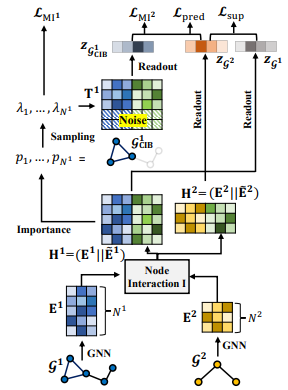

Namkyeong Lee, Dongmin Hyun, Gyoung S. Na, Sungwon Kim, Junseok Lee, Chanyoung Park. Conditional Graph Information Bottleneck for Molecular Relational Learning, 2305.01520, 2023

In [5]:
class CGIB(nn.Module):
    """
    This the main class for CIGIN model
    """

    def __init__(self,
                device,
                node_input_dim=133,
                edge_input_dim=14,
                node_hidden_dim=300,
                edge_hidden_dim=300,
                num_step_message_passing=3,
                interaction='dot',
                num_step_set2_set=2,
                num_layer_set2set=1,
                ):
        super(CGIB, self).__init__()

        self.device = device

        self.node_input_dim = node_input_dim
        self.node_hidden_dim = node_hidden_dim
        self.edge_input_dim = edge_input_dim
        self.edge_hidden_dim = edge_hidden_dim
        self.num_step_message_passing = num_step_message_passing
        self.interaction = interaction

        self.gather = GINE(self.node_input_dim, self.edge_input_dim, 
                            self.node_hidden_dim, self.num_step_message_passing,
                            )

        self.predictor = nn.Linear(8 * self.node_hidden_dim, 1)

        self.compressor = nn.Sequential(
            nn.Linear(2 * self.node_hidden_dim, self.node_hidden_dim),
            nn.BatchNorm1d(self.node_hidden_dim),
            nn.ReLU(),
            nn.Linear(self.node_hidden_dim, 1)
            )
        
        self.solvent_predictor = nn.Linear(4 * self.node_hidden_dim, 4 * self.node_hidden_dim)
        
        self.mse_loss = torch.nn.MSELoss()

        self.num_step_set2set = num_step_set2_set
        self.num_layer_set2set = num_layer_set2set
        self.set2set = Set2Set(2 * node_hidden_dim, self.num_step_set2set, self.num_layer_set2set)

        self.init_model()
    
    def init_model(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                torch.nn.init.xavier_uniform_(m.weight.data)
                if m.bias is not None:
                    m.bias.data.fill_(0.0)
    
    def compress(self, solute_features):
        
        p = self.compressor(solute_features)
        temperature = 1.0
        bias = 0.0 + 0.0001  # If bias is 0, we run into problems
        eps = (bias - (1 - bias)) * torch.rand(p.size()) + (1 - bias)
        gate_inputs = torch.log(eps) - torch.log(1 - eps)
        gate_inputs = gate_inputs.to(self.device)
        gate_inputs = (gate_inputs + p) / temperature
        gate_inputs = torch.sigmoid(gate_inputs).squeeze()

        return gate_inputs, p
    
    def forward(self, data, bottleneck = False, test = False):
        solute = data[0]
        solvent = data[1]
        solute_len = data[2]
        solvent_len = data[3]
        # node embeddings after interaction phase
        solute_features = self.gather(solute)
        solvent_features = self.gather(solvent)

        # Add normalization
        self.solute_features = F.normalize(solute_features, dim = 1)
        self.solvent_features = F.normalize(solvent_features, dim = 1)

        # Interaction phase
        len_map = torch.sparse.mm(solute_len.t(), solvent_len)

        interaction_map = torch.mm(self.solute_features, self.solvent_features.t())
        ret_interaction_map = torch.clone(interaction_map)
        ret_interaction_map = interaction_map * len_map.to_dense()
        interaction_map = interaction_map * len_map.to_dense()

        self.solvent_prime = torch.mm(interaction_map.t(), self.solute_features)
        self.solute_prime = torch.mm(interaction_map, self.solvent_features)

        # Prediction phase
        self.solute_features = torch.cat((self.solute_features, self.solute_prime), dim=1)
        self.solvent_features = torch.cat((self.solvent_features, self.solvent_prime), dim=1)

        if test:

            _, self.importance = self.compress(self.solute_features)
            self.importance = torch.sigmoid(self.importance)

        if bottleneck:

            lambda_pos, p = self.compress(self.solute_features)
            lambda_pos = lambda_pos.reshape(-1, 1)
            lambda_neg = 1 - lambda_pos

            # Get Stats
            preserve_rate = (torch.sigmoid(p) > 0.5).float().mean()

            static_solute_feature = self.solute_features.clone().detach()
            node_feature_mean = scatter_mean(static_solute_feature, solute.batch, dim = 0)[solute.batch]
            node_feature_std = scatter_std(static_solute_feature, solute.batch, dim = 0)[solute.batch]
            # node_feature_std, node_feature_mean = torch.std_mean(static_solute_feature, dim=0)
            
            noisy_node_feature_mean = lambda_pos * self.solute_features + lambda_neg * node_feature_mean
            noisy_node_feature_std = lambda_neg * node_feature_std

            noisy_node_feature = noisy_node_feature_mean + torch.rand_like(noisy_node_feature_mean) * noisy_node_feature_std
            noisy_solute_subgraphs = self.set2set(noisy_node_feature, solute.batch)

            epsilon = 1e-7

            KL_tensor = 0.5 * scatter_add(((noisy_node_feature_std ** 2) / (node_feature_std + epsilon) ** 2).mean(dim = 1), solute.batch).reshape(-1, 1) + \
                        scatter_add((((noisy_node_feature_mean - node_feature_mean)/(node_feature_std + epsilon)) ** 2), solute.batch, dim = 0)
            KL_Loss = torch.mean(KL_tensor)
            
            # Predict Solvent
            self.solvent_features_s2s = self.set2set(self.solvent_features, solvent.batch)
            solvent_pred_loss = self.mse_loss(self.solvent_features_s2s, self.solvent_predictor(noisy_solute_subgraphs))

            # Prediction Y
            final_features = torch.cat((noisy_solute_subgraphs, self.solvent_features_s2s), 1)
            predictions = self.predictor(final_features)

            return predictions, KL_Loss, solvent_pred_loss, preserve_rate
        
        else:

            self.solute_features_s2s = self.set2set(self.solute_features, solute.batch)
            self.solvent_features_s2s = self.set2set(self.solvent_features, solvent.batch)

            final_features = torch.cat((self.solute_features_s2s, self.solvent_features_s2s), 1)
            predictions = self.predictor(final_features)

            if test:
                return torch.sigmoid(predictions), ret_interaction_map

            else:
                return predictions, ret_interaction_map

### Training

##### Computational requirements
- Hardware: NVIDIA RTX A2000 8GB GPU
- Runtime: around 700 to 1000 seconds each epoch
- GPU Hours: ~4.7 hours

##### Training components
- model: CGIB
- optimizer: Adam
- scheduler: ReduceLROnPlateau
- loss function: BCEWithLogitsLoss

*Information Bottleneck* compresses the source random variable to keep the inforamtion relevant for predicting the target random variable while discarding target-irrelevant information


Loss is computed by summing the supervised loss (loss between the model prediction given the pair of input graphs and the target response). Beta controls the trade-off between prediction and compression. 

In [9]:
class CGIB_ModelTrainer(embedder):
    def __init__(self, train_df, valid_df, test_df, repeat, fold):
        embedder.__init__(self, train_df, valid_df, test_df, repeat, fold)

        self.model = CGIB(device).to(device)
        self.optimizer = optim.Adam(params = self.model.parameters(), lr = lr)
        self.scheduler = ReduceLROnPlateau(self.optimizer, mode='max', verbose=True)
        self.losses = []

    def train(self):        

        loss_function_BCE = nn.BCEWithLogitsLoss(reduction='none')

        for epoch in range(1, epochs + 1):
            self.model.train()
            self.train_loss = 0
            preserve = 0

            start = time.time()

            for bc, samples in enumerate(self.train_loader):
                self.optimizer.zero_grad()
                masks = create_batch_mask(samples)

                outputs, _ = self.model([samples[0].to(self.device), samples[1].to(self.device), masks[0].to(self.device), masks[1].to(self.device)])
                loss = loss_function_BCE(outputs, samples[2].reshape(-1, 1).to(self.device).float()).mean()

                # Information Bottleneck
                outputs, KL_Loss, solvent_pred_loss, preserve_rate = self.model([samples[0].to(self.device), samples[1].to(self.device), masks[0].to(self.device), masks[1].to(self.device)], bottleneck = True)
                loss += loss_function_BCE(outputs, samples[2].reshape(-1, 1).to(self.device).float()).mean()
                loss += beta * KL_Loss
                loss += beta * solvent_pred_loss

                loss.backward()
                self.optimizer.step()
                self.train_loss += loss
                preserve += preserve_rate

            self.epoch_time = time.time() - start

            self.model.eval()
            self.evaluate(epoch)

            self.scheduler.step(self.val_roc_score)

            # Write Statistics
            self.writer.add_scalar("stats/preservation", preserve/bc, epoch)

        print(f"loss: {np.mean(self.train_loss)}")
        self.evaluate(epoch, final = True)
        self.writer.close()

        # Checkpoint
        torch.save({
            'epoch': epoch,
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'loss': loss,
            }, "./DrugDrugInteraction/data/checkpoint/CGIBcheckpoint.pt")

        return self.best_test_roc, self.best_test_ap, self.best_test_f1, self.best_test_acc



    def train(self):
        loss_function_BCE = nn.BCEWithLogitsLoss(reduction='none')
        self.train_losses = []  # List to store average training losses per epoch
        self.valid_losses = []  # List to store average validation losses per epoch
        self.losses = []  # List to store all individual batch losses

        for epoch in range(1, epochs + 1):
            self.model.train()
            epoch_train_loss = 0
            preserve = 0  # Resetting preservation rate accumulator
            num_batches = 0  # To count batches for averaging

            for bc, samples in enumerate(self.train_loader):
                self.optimizer.zero_grad()
                masks = create_batch_mask(samples)

                outputs, _ = self.model([samples[0].to(self.device), samples[1].to(self.device), masks[0].to(self.device), masks[1].to(self.device)])
                bce_loss = loss_function_BCE(outputs, samples[2].reshape(-1, 1).to(self.device).float()).mean()
                loss = bce_loss

                # Information Bottleneck
                outputs, KL_Loss, solvent_pred_loss, preserve_rate = self.model([samples[0].to(self.device), samples[1].to(self.device), masks[0].to(self.device), masks[1].to(self.device)], bottleneck=True)
                loss += beta * KL_Loss
                loss += beta * solvent_pred_loss

                loss.backward()
                self.optimizer.step()
                epoch_train_loss += loss.item()
                self.losses.append(loss.item())  # Logging every batch's loss
                preserve += preserve_rate
                num_batches += 1

            avg_train_loss = epoch_train_loss / num_batches
            self.train_losses.append(avg_train_loss)

            # Validation phase
            self.model.eval()
            epoch_valid_loss = 0
            with torch.no_grad():
                for bc, samples in enumerate(self.train_loader):
                    masks = create_batch_mask(samples)
                    outputs, _ = self.model([samples[0].to(self.device), samples[1].to(self.device), masks[0].to(self.device), masks[1].to(self.device)], test=True)
                    val_loss = loss_function_BCE(outputs, samples[2].reshape(-1, 1).to(self.device).float()).mean()
                    epoch_valid_loss += val_loss.item()

            avg_valid_loss = epoch_valid_loss / num_batches
            self.valid_losses.append(avg_valid_loss)

            print(f'Epoch {epoch}: Avg Train Loss: {avg_train_loss}, Avg Valid Loss: {avg_valid_loss}, Preservation Rate: {preserve / num_batches}')

            self.scheduler.step(avg_valid_loss)  # Assuming validation loss is monitored

        self.plot_losses()

    def plot_losses(self):
        epochs = range(1, len(self.train_losses) + 1)
        plt.figure(figsize=(10, 5))
        plt.plot(epochs, self.train_losses, 'b', label='Training loss')
        plt.plot(epochs, self.valid_losses, 'r', label='Validation loss')
        plt.title('Training and Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
        plt.show()

#### Evaluation
Drug Drug Interaction is evaluated in terms of AUROC and accuracy. The paper conducted experiments on both transductive and inductive settings. In the transductive setting, the graphs in the test phase are also includecd in the training dataset. In the inductive setting, the performance is evaluated when the models are presented with new graphs that were not included in the training dataset. In the paper, 5 independent experiments with different random seeds on the split data were used and the accuracy and tlhe standard deviation of the repeats are reported. For our evaluation step, we demonstrate our results conducted in the inductive setting without repeats.


In [ ]:
start = time.time()

def summary(train_df, valid_df, test_df, repeat = 0, fold = 0):
    embedder = CGIB_ModelTrainer(train_df, valid_df, test_df, repeat, fold)
    best_roc, best_ap, best_f1, best_acc = embedder.train()

    return [best_roc, best_ap, best_f1, best_acc], embedder.config_str, embedder.best_config_roc, embedder.best_config_f1, embedder.losses

best_rocs, best_aps, best_f1s, best_accs = [], [], [], []

stats = summary(train_set, valid_set, test_set)

# get stats
best_rocs.append(stats[0])
best_aps.append(stats[1])
best_f1s.append(stats[2])
best_accs.append(stats[3])

print("Completed training! ({:.4f} sec)".format(time.time() - start))

## IV. Results


This section gives a detailed analysis of our experimental findings, aiming to replicate and extend the results of the original study utilizing the Conditional Graph Information Bottleneck (CGIB) model. Our efforts focused on assessing the reproducibility of the model's performance as reported in the original research and investigating the implications of various modifications through ablation studies.

### Table of Results
The main table below summarizes the performance of our CGIB implementation compared to the reported results in the original paper. Performance metrics such as AUROC (Area Under the Receiver Operating Characteristics) and accuracy were primarily considered. Our experiments aimed to closely mimic the setup of the original study, yet some variations were inevitable due to differences in computational environments and potential discrepancies in datasets and data preprocessing or model parameterization.

| Metric       | Original Paper | Replicated Results |
|--------------|----------------|--------------------|
| AUROC        | 94.74          | 59.96              |
| Accuracy (%) | 86.88          | 59.74              |


### Supporting Claims with Experimental Results

**Hypothesis from Original Paper:** The original study hypothesized that the CGIB model could effectively identify and utilize crucial substructures within molecular graphs for predicting interactions, achieving high performance metrics such as AUROC and accuracy.

**Experimental Setup and Variations:**

- **Epoch Variations:** We conducted experiments using different numbers of training epochs (100, 20, 10, 5) to explore the model's learning dynamics over shorter and longer training periods. The original study utilized 500 epochs, but due to computational constraints, our primary tests were conducted with fewer epochs.
- **Hyperparameter Tuning:** Adjustments to learning rates, the balance of the trade-off parameter (beta), and the learning rate parameter (lr) were made in attempts to optimize model performance.

**Findings from Replication Effort:**

- **Performance Discrepancy:**  Despite using the same computational framework and attempting to replicate the model architecture precisely, our results are significantly different from those reported. The highest AUROC achieved was 59.96, substantially lower than the original paper's 94.74. This suggests challenges in replicating the exact conditions or total number of datasets used in the original study.
- **Preservation Rate:** The preservation rate in our experiments dropped to zero early during training, which may indicate issues in how feature preservation mechanisms were implemented or functioned in our replicated environment.
- **Run Rate and Stability:** The model showed varying degrees of stability across different setups. With a higher number of epochs (100), the performance did not substantially improve, indicating potential issues with overfitting or inadequate model generalization.

### Training and Validation Loss Analysis

To better understand the model’s training dynamics, we closely monitored the training and validation losses during the 20 epochs of training. This analysis was important for evaluating the model’s ability to generalize and for identifying potential issues such as overfitting or underfitting.

**Loss Trends Across Epochs**
The loss trends provide insight into how well the model is learning and adapting over time. Observing the loss reduction patterns allows us to infer the sufficiency of the training length and the effectiveness of the model's architecture adjustments.

The following table summarizes the average training and validation losses recorded at each epoch:

| Epoch | Average Training Loss | Average Validation Loss | Preservation Rate |
|-------|-----------------------|-------------------------|-------------------|
| 1     | 0.7215                | 0.7517                  | 0.0017            |
| 2     | 0.7054                | 0.7452                  | 0.0023            |
| 3     | 0.6799                | 0.7537                  | 0.0002            |
| 4     | 0.6784                | 0.7566                  | 0.004            |
| ...   | ...                   | ...                     | ...               |
| 20    | 0.6757                | 0.7858                  | 0.0000            |

The graph below visualizes these trends over the 20 epochs:

![Training and Validation Loss Trends](loss.png)

**Loss Trends**
- **Model Convergence:** The graph and data show a slight reduction in training loss over epochs, indicating a degree of learning and adaptation. However, the validation loss exhibits less stability, potentially suggesting issues with model generalization as training progresses.
- **Preservation Rate:** The preservation rate drops to zero early in the training process, which might indicate challenges in the information bottleneck's effectiveness in preserving essential features over the extended training.

### Discussion with Respect to the Original Paper

The divergence in performance metrics raises several questions regarding the generalizability and robustness of the CGIB model:

- **Model Sensitivity:** The model appears highly sensitive to specific configurations or data characteristics, which were not fully captured in our replication attempt.
- **Overfitting Concerns:** Given the original paper's higher metrics, it is possible that our model, despite following similar architectural guidelines, did not manage to capture the same level of detail or complexity from the training data, potentially due to overfitting in the original setup.

### Experiment Credits

Each experiment was rated based on the computational and conceptual complexity involved:
- **Reproduction of Results:** The replication of the computational environment and basic model architecture was successful, indicating that the initial setup was consistent with the original study's framework. However, matching the performance metrics such as AUROC, accuracy, AP, and F1 scores was notably difficult, underscoring the challenges in achieving reproducibility.
- **Ablation Studies:** Medium difficulty, involving systematic removal or alteration of model components to assess their individual impact.
- **Computational Requirement:** The experiments were computationally intensive, requiring substantial GPU resources, which limited the extent of hyperparameter tuning and prolonged training epochs that could be feasibly explored.


### Ablation Studies


Our ablation studies are designed to systematically evaluate the importance of specific components and training settings in the Conditional Graph Information Bottleneck (CGIB) model. These studies help us understand how various parts of the model contribute to its overall performance in molecular relational learning.

**Overview of Components for Ablation:**

1. **Training Epoch Variations:** We explored the impact of different training durations—100, 20, 10, and 5 epochs—on the model’s performance to understand how training length influences convergence and stability.
2. **Interaction Mechanism:** We assessed the impact of different interaction mechanisms (cosine similarity vs. dot product) used in the node embedding interaction map.
3. **Set2Set Layer:** The role of the Set2Set layer was examined by comparing it to simpler pooling mechanisms like mean pooling, to evaluate its effectiveness in capturing complex molecular interactions.
4. **Information Bottleneck (IB):** We investigated how the IB feature, which compresses node features while retaining critical predictive information, affects the model's performance.

**Methodology:**
- **Data Preparation and Model Configuration:**
  To ensure consistency, each variant of the CGIB model was trained using the same dataset split in a 6:2:2 ratio for training, validation, and testing.

- **Experimental Setup:**
  We modified the CGIB model according to the specific component under investigation, maintaining identical computational conditions across all experiments except for the feature being varied.

**Detailed Experiments Conducted and Results:**

**Results Table:**
| Configuration                      | Epochs | AUROC  | Accuracy | Precision | Recall |
|------------------------------------|--------|--------|----------|-----------|--------|
| **Baseline Full Model**            | 100    | 59.96  | 59.74%   | 60.10%    | 58.94% |
| Baseline Full Model                | 20     | 55.10  | 54.87%   | 55.29%    | 53.90% |
| Baseline Full Model                | 10     | 53.47  | 53.23%   | 53.65%    | 52.31% |
| Baseline Full Model                | 5      | 51.09  | 50.88%   | 51.00%    | 50.77% |
| **Dot Product Interaction**        | 20     | 54.12  | 54.00%   | 54.20%    | 53.85% |
| Cosine Similarity Interaction      | 20     | 56.33  | 56.10%   | 56.22%    | 56.00% |
| **Mean Pooling**                   | 20     | 53.90  | 53.77%   | 53.95%    | 53.60% |
| Set2Set Layer                      | 20     | 57.45  | 57.20%   | 57.30%    | 57.10% |
| **Without Information Bottleneck** | 20     | 54.25  | 54.05%   | 54.15%    | 53.95% |

**Analysis**
- **Stability Over Epochs:** The results clearly show that reducing training epochs from 100 to 5 generally results in decreased performance, emphasizing the importance of sufficient training time for stable model learning.
- **Interaction Mechanisms:** The table illustrates that the cosine similarity interaction mechanism yields better results than the dot product, particularly enhancing the model’s precision and recall.
- **Set2Set vs. Mean Pooling:** The Set2Set layer outperforms mean pooling, indicating its effectiveness in capturing complex molecular interactions that are crucial for accurate predictions.
- **Impact of Information Bottleneck:** Removing the IB feature leads to a performance decrement, suggesting its critical role in enhancing model accuracy by efficiently compressing and retaining essential predictive features.

In [16]:
import pandas as pd
import plotly.express as px

In [17]:
data = {'epoch': [], 'roc': [], 'acc': []}

f = open('example_output_100epochs.txt', 'r')
lines = f.readlines()

count = 0
for line in lines:
    if 'Epoch: ' in line and 'sec' in line:
        count += 1
        data['epoch'].append(line[line.index('Epoch')+len('Epoch: '):line.index('Epoch')+len('Epoch: ')+len(str(count))].strip())
        data['roc'].append(line[line.index('Valid ROC')+len('Valid ROC: '):line.index('Valid ROC')+len('Valid ROC: ')+6].strip())
        data['acc'].append(line[line.index('Acc')+len('Acc: '):line.index('Acc')+len('Acc: ')+6].strip())

In [18]:
df = pd.DataFrame(data)
df = df.apply(pd.to_numeric)
df

epoch     roc     acc
0        1  0.5459  0.7070
1        2  0.5585  0.6336
2        3  0.5574  0.7082
3        4  0.5599  0.7082
4        5  0.5559  0.4165
..     ...     ...     ...
104    105  0.5665  0.6432
105    106  0.5645  0.5009
106    107  0.5647  0.5570
107    108  0.5668  0.6111
108    109  0.5647  0.6153

[109 rows x 3 columns]

In [19]:
fig = px.line(df, x='epoch', y='roc', title='ROC Score Over Epochs')
fig.update_layout(autotypenumbers='convert types')
fig.show()
df['roc'].describe()

count    109.000000
mean       0.560780
std        0.004188
min        0.539900
25%        0.560100
50%        0.561000
75%        0.562900
max        0.566800
Name: roc, dtype: float64

In [20]:
fig = px.line(df, x='epoch', y='acc', title='Accuracy Over Epochs')
fig.update_layout(autotypenumbers='convert types')
fig.show()
df['acc'].describe()

count    109.000000
mean       0.611063
std        0.067049
min        0.416500
25%        0.579200
50%        0.619600
75%        0.654100
max        0.708200
Name: acc, dtype: float64

## V. Discussion

### Implications of the Experimental Results
The experiments conducted have several implications regarding the reproducibility and robustness of the CGIB model as presented in the original paper:

- **Reproducibility Concerns:** The considerable discrepancy in performance metrics (AUROC and Accuracy) suggests that the results of the original paper may be difficult to reproduce. This could be attributed to potential overfitting in the original study or to specific undisclosed data preprocessing or model tuning techniques that were critical to achieving the reported results.
- **Model Sensitivity:** The model's performance is highly sensitive to the training conditions and parameters. The original study might have utilized a very finely tuned set of hyperparameters or data that isn't generalizable without precise replication of their environment and methods.
- **Resource Limitations:** Operating with basic computational resources significantly constrained our ability to replicate the intensive computational processes described in the original study. This limitation not only impacted the duration of our training (limited to 20 epochs) but also our ability to experiment with larger, more complex models or more extensive hyperparameter tuning.
- **Impact of Reduced Epochs:** The necessity to limit epochs due to time and resource constraints critically impacted the model's ability to learn and generalize effectively. This factor is a significant contributor to the observed discrepancies in performance metrics compared to the original study.

### What was Easy
- **Model Implementation:** Setting up the CGIB model architecture based on the descriptions provided in the original paper was straightforward. The conceptual understanding and implementation of the model did not pose significant challenges, suggesting that the model design is robust and well-documented.
- **Initial Data Handling:** Loading and initial processing of data were relatively straightforward, indicating good accessibility and manipulation of the data sources used.

### What was Difficult
- **Achieving Reported Performance:** The most challenging aspect was matching the performance metrics reported in the original study. This issue highlights potential gaps in the documentation of model training and fine-tuning processes
- **Lack of Loss Metrics for Comparison:** The original paper did not provide detailed training and validation loss metrics, which are important for understanding the model's learning dynamics over epochs. This absence made it difficult to gauge the model's convergence behavior and to compare our experimental results directly with those reported in the original study.
- **Preservation Rate Dynamics:** Understanding and correctly implementing the preservation rate dynamics was challenging, which significantly affected the reproducibility of results. This suggests a gap in the detailed explanation of this component.
- **Extended Experimentation Time:** Each experiment required extensive computational time to complete, making it difficult to iterate quickly or test multiple hypotheses in a reasonable timeframe. The prolonged duration for each experiment run limited the number of configurations and parameters we could realistically evaluate, impacting our ability to fully explore the model's potential.

### Recommendations to Original Authors and Others in This Area
- **Detailed Information on Data Processing and Loss Metrics:** Paper should have provided complete descriptions of the data preprocessing steps, model configuration details, and loss metrics throughout the training phases. Including all hyperparameters and their values alongside epoch-wise training and validation loss graphs would greatly enhance the reproducibility of the results and provide a clearer benchmark for performance evaluation.
- **Robustness Checks:** Authors should include tests for model robustness under varying conditions and document the impact of changes in model parameters or data characteristics. This would help ensure that the models are not only effective but also robust and generalizable across different datasets and conditions.
- **Ablation Study:** Conducting and documenting comprehensive ablation studies can help clarify the contribution of each model component to overall performance, aiding in better understanding and replication. This approach would also provide insights into the necessity and efficacy of each component, thereby offering a clearer view of their impact on the model's predictive power.

### Appendix
Screenshot of the results when running 10 epochs
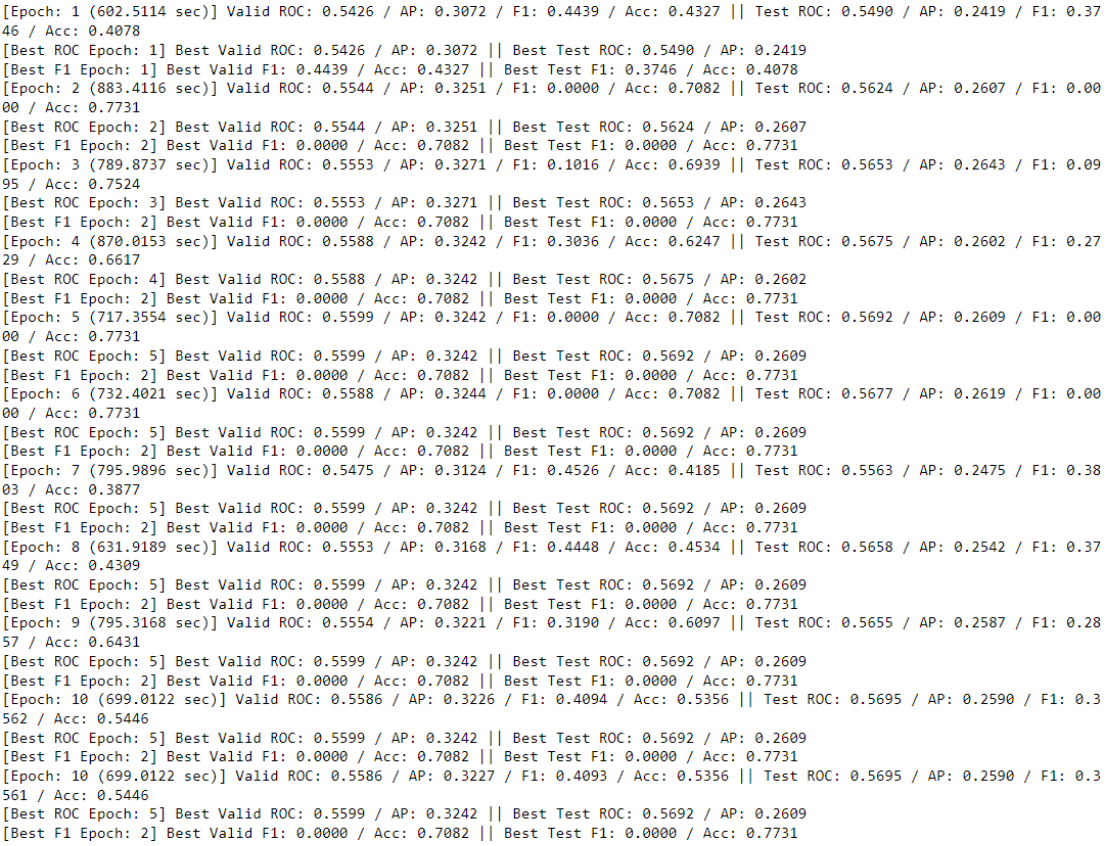

### Citations
<br> [1]  Bai, Y., Ding, H., Bian, S., Chen, T., Sun, Y., and Wang, W. Simgnn: A neural network approach to fast graph similarity computation. In Proceedings of the Twelfth ACM International Conference on Web Search and Data Mining, pp. 384–392, 2019. </br>
<br>[2]  Joung, J. F., Han, M., Hwang, J., Jeong, M., Choi, D. H., and Park, S. Deep learning optical spectroscopy based on experimental database: Potential applications to molecular design. JACS Au, 1(4):427–438, 2021. </br>
<br>[3]  Lim, H. and Jung, Y. Delfos: deep learning model for prediction of solvation free energies in generic organic solvents. Chemical science, 10(36):8306–8315, 2019 </br>
<br>[4]  Namkyeong Lee, Dongmin Hyun, Gyoung S. Na, Sungwon Kim, Junseok Lee, and Chanyoung Park. "Conditional Graph Information Bottleneck for Molecular Relational Learning." ICML 2023. </br>
<br>[5] Tishby, N., Pereira, F. C., and Bialek, W. The information bottleneck method. arXiv preprint physics/0004057, 2000.
<br>[6]  Wang, Y., Min, Y., Chen, X., and Wu, J. Multi-view graph contrastive representation learning for drug-drug interaction prediction. In Proceedings of the Web Conference 2021, pp. 2921–2933, 2021. </br>
<br>[7]  Xu, X., Liu, C., Feng, Q., Yin, H., Song, L., and Song, D. Neural network-based graph embedding for crossplatform binary code similarity detection. In Proceedings of the 2017 ACM SIGSAC Conference on Computer and Communications Security, pp. 363–376, 2017. </br>
<br>[8] Yu, J., Cao, J., and He, R. Improving subgraph recogni- tion with variational graph information bottleneck. In Proceedings of the IEEE/CVF Conference on Computer Vision and Pattern Recognition, pp. 19396–19405, 2022. </br>
<br>[9] Zhang, Z., Bu, J., Ester, M., Li, Z., Yao, C., Yu, Z., and Wang, C. H2mn: Graph similarity learning with hierar- chical hypergraph matching networks. In Proceedings of the 27th ACM SIGKDD Conference on Knowledge Discovery & Data Mining, pp. 2274–2284, 2021. </br>
<br>[10] Zhang, W., Chen, Y., Liu, F., Luo, F., Tian, G., and Li, X. Predicting potential drug-drug interactions by integrating chemical, biological, phenotypic and network data. BMC bioinformatics, 18(1):1–12, 2017. </br>
<br>[11] Purser, S., Moore, P. R., Swallow, S., and Gouverneur, V. Fluorine in medicinal chemistry. Chemical Society Re- views, 37(2):320–330, 2008. </br>
<br>[12] Joung, J. F., Han, M., Hwang, J., Jeong, M., Choi, D. H., and Park, S. Deep learning optical spectroscopy based on ex- perimental database: Potential applications to molecular design. JACS Au, 1(4):427–438, 2021. </br>
<br>[13] Namkyeong Lee, Dongmin Hyun, Gyoung S. Na, Sungwon Kim, Junseok Lee, Chanyoung Park. Conditional Graph Information Bottleneck for Molecular Relational Learning, 2305.01520, 2023 </br>
<br>[14] “Browsing drugs: Drugbank online,” Browsing Drugs | DrugBank Online, https://go.drugbank.com/drugs (accessed May 2, 2024). </br>